# Yield Rate Gender Gap, Part 5: Exploratory Data Analysis

*This is Part 5 of an investigation into the yield rate disparity in college admissions between women and men. This is a personal project I started to help me tie together using python for web scraping, data cleaning, data visualization, hypothesis testing, statistical modeling, machine learning, and more. I appreciate feedback!*

---

## Size and number of schools

We have 1676 schools remaining in our dataset after scraping schools' data from CollegeData.com in Part 1, cleaning that dataset in Part 2, joining that dataset with the rankings scraped from US News and World Report in Part 3, and finally imputing missing values (and dropping schools missing all admissions values) in Part 4.

US News splits schools into different **rank types** before giving rankings. They are:
- National Universities
- National Liberal Arts Colleges
- Regional Universities North
- Regional Universities South
- Regional Universities Midwest
- Regional Universities West
- Regional Colleges North
- Regional Colleges South
- Regional Colleges Midwest
- Regional Colleges West

We combined the regional schools to just two categories, and marked unranked schools as such. For reasons that will become apparent further in this analysis, the 50 best ranked National Universities and, to a lesser extent, the National Liberal Arts Colleges are so different from the rest of the schools in their categories that I have separated them out, giving us a total of seven **rank types**:
- Top 50 Universities
- Top 50 Colleges
- National Universities *(excluding the Top 50 Universities)*
- National Colleges *(excluding the Top 50 Colleges)*
- Regional Universities
- Regional Colleges
- Unranked Schools

Let's take a look at how many schools are in each category and how many students attend schools in these categories:

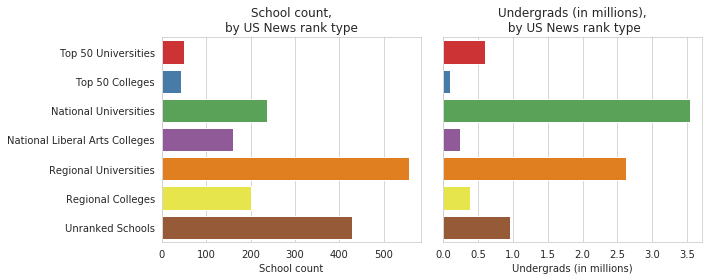

,School count,Total undergrads (in millions),Percent of total US undergrads,Average undergrads per school
Rank Type,,,,
Top 50 Universities,50,0.60,7.11,11999
Top 50 Colleges,43,0.09,1.12,2194
National Universities,237,3.54,41.91,14918
National Liberal Arts Colleges,160,0.24,2.87,1511
Regional Universities,556,2.62,31.07,4715
Regional Colleges,202,0.39,4.64,1938
Unranked Schools,428,0.95,11.29,2225
All Schools,1676,8.44,100.00,5034


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# Retreived on 2018-10-25 from US Census at:
# https://www.census.gov/quickfacts/fact/table/US/PST045217
US_BASELINE = 50.8
US_BASELINE_DIFF = 100 * (US_BASELINE - (100 - US_BASELINE)) / (100 - US_BASELINE)

# Set display options.
sns.set_style("whitegrid")
sns.set_palette('Set1')
pd.options.display.float_format = '{:,.2f}'.format

# Import previously imputed dataframe.
df = pd.read_csv('data/imputed_college.csv', index_col=0, header=[0,1])

# Set and order categories, including new Top 50 Colleges category.
cat = ('Category','Rank Type')
df.loc[df[cat]=='Unranked',cat] = 'Unranked Schools'
df[cat] = df[cat].astype('category')
df[cat].cat.add_categories('Top 50 Colleges', inplace=True)
libarts = df[cat] == 'National Liberal Arts Colleges'
top50 = df['Rank','Rank Number'] <= 50
df.loc[libarts & top50, cat] = 'Top 50 Colleges'
cats = ['Top 50 Universities','Top 50 Colleges','National Universities',
        'National Liberal Arts Colleges','Regional Universities',
        'Regional Colleges','Unranked Schools']
df[cat].cat.reorder_categories(cats, inplace=True)

# Create dataframe to hold group sums for each rank type.
cols = ['Apps','Offers','Enrolled','Undergrads']
sums = df.groupby(cat).sum()[cols].astype('int')
sums['Schools','School count'] = df.groupby(cat).size()
sums.index = sums.index.add_categories('All Schools')
sums.rename_axis('Rank Type', inplace=True)
sums.loc['All Schools'] = sums.sum()

# Calculate group offer rate, yield rates, and freshmen ratio values.
for gender in ['All','Men','Women']:
    sums['Offer Rate', gender] = \
        sums['Offers', gender] / sums['Apps', gender]
    sums['Yield Rate', gender] = \
        sums['Enrolled', gender] / sums['Offers', gender]
    sums['Freshmen Ratio', gender] = \
        sums['Enrolled', gender] / sums['Undergrads', gender]


# Calculate group percent women and difference from US_BASELINE.
for col in ['Apps','Offers','Enrolled','Undergrads']:
    sums[col,'Percent Women'] = 100*sums[col,'Women'] / sums[col,'All']
    sums[col,'Diffs'] = 100 * (sums[col,'Percent Women'] - US_BASELINE) / US_BASELINE

    
# Calculate group rate differences.
cols = ['Offer Rate','Yield Rate','Freshmen Ratio']
for col in cols:
    sums[col,'Diffs'] = 100*(sums[col,'Women'] - sums[col,'Men'])/sums[col,'Men']


# Create figure.
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)

cols = [('Schools','School count'), ('Undergrads','All')]
plot_data = sums[cols].drop('All Schools')
plot_data.columns = plot_data.columns.droplevel(1)
plot_data.columns = ['School count','Undergrads (in millions)']
plot_data['Undergrads (in millions)'] /= 1e6
plot_data.index = plot_data.index.remove_unused_categories()

ax1.set_title('School count,\nby US News rank type')
sns.barplot(x=plot_data['School count'], y=plot_data.index, ax=ax1)
ax1.set_xlabel('School count')
ax1.set_ylabel('')

sns.barplot(x=plot_data['Undergrads (in millions)'], y=plot_data.index, ax=ax2)
ax2.set_title('Undergrads (in millions),\n by US News rank type')
ax2.set_xlabel('Undergrads (in millions)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()


# Define new values for table to display.
sums['Undergrads','Percent of total US undergrads'] = \
    100*sums['Undergrads']['All'] / sums.loc['All Schools']['Undergrads']['All']
    
sums['Undergrads','Average undergrads per school'] = \
    sums['Undergrads']['All'] / sums['Schools']['School count']
    

# Display table.
cols = [('Schools','School count'), ('Undergrads','All'),
        ('Undergrads','Percent of total US undergrads'),
        ('Undergrads','Average undergrads per school')]

table = sums[cols].copy()
table.columns = table.columns.droplevel(0)
table.rename(columns={'All':'Total undergrads (in millions)'}, inplace=True)
table['Total undergrads (in millions)'] /= 1e6
table['Average undergrads per school'] = table['Average undergrads per school'].astype('int')
table

If you attended a Top 50 University or Top 50 College - congratulations! Only ~8% of undergraduates are attending such schools. Coupled with the fact [only 33% of Americans over 25 years old have earned a bachelor's degree](https://www.census.gov/content/dam/Census/library/publications/2016/demo/p20-578.pdf), that would put you in the  2.6% educated elite of the American population. If your professional and personal social groups consist mostly of other educated elite, consider the strength of the filter bubble through which you are experiencing American society, and consider how radically different the perspectives could be that come from the bubbles of other people.

The overwhelming majority of Americans do not have a bachelor's degree. But of those that are working toward one, ~73% are in a non-Top 50 US News ranked University, either National or Regional, whereas only ~8% are in what US News calls a ranked College.

At 15,000 students per school on average, the largest schools are the National Universities, nearly 3 times as large as typical Regional Universities, and 10 times as large as National Liberal Arts Colleges.

In total, I have an estimated count of 8.44 million students currently enrolled in these four year institutions. According to the National Center for Education Statistics, [there are 9.48 million students projected to attend 4 year colleges full time in 2018](https://nces.ed.gov/programs/digest/d17/tables/dt17_303.30.asp), making my total ~10% short. This ~1 million student gap could be due to me previously dropping coeducational schools, dropping schools missing all enrollment data, and not having information from schools that had no CollegeData.com or US News entries to scrape. 

I would imagine the majority of the unaccounted ~1 million undergraduates are enrolled in schools similar to those in the Unranked Schools category. If true, it would further lower the previously mentioned percentages.

---

## Applicant SAT scores

We have data for the mean GPA, ACT, and SAT scores of the Enrolled freshmen, as well as the portion of the Enrolled freshmen that were ranked in the Top 10th Percent and the Bottom 50th Percent:

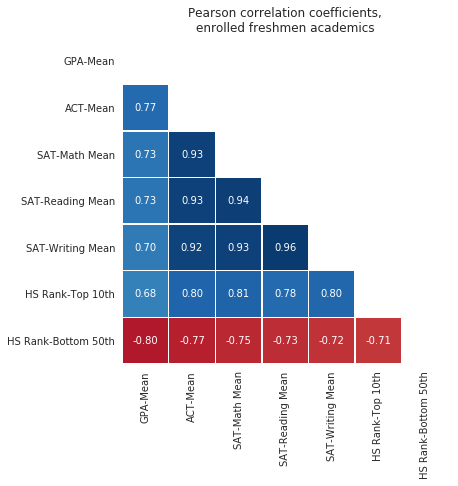

In [48]:
cols = ['GPA','ACT','SAT','HS Rank']
corr = df[cols].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))


sns.heatmap(corr, mask=mask, center=0, cmap='RdBu', annot=True, cbar=False,
            fmt=".2f", square=True, linewidths=.5)
plt.title('Pearson correlation coefficients,\nenrolled freshmen academics')
plt.xlabel('')
plt.ylabel('')
plt.show()

These quantities all so strongly correlate with each other that I will use the only the SAT Math Mean going forward to represent the academic strength of the Enrolled freshmen.

Let's take a look at the [emperical cumulative distribution functions (ECDFs)](https://en.wikipedia.org/wiki/Empirical_distribution_function) of the SAT Math Mean across our different US News rank type categories:

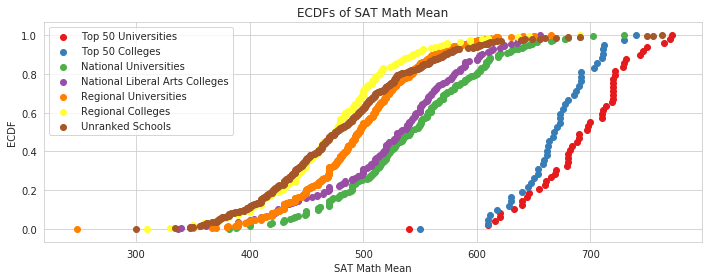

,SAT Math 25th percentile,SAT Math 50th percentile,SAT Math 75th percentile
Rank Type,,,
Top 50 Universities,662,693,720
Top 50 Colleges,649,668,691
National Universities,498,541,585
National Liberal Arts Colleges,488,531,569
Regional Universities,463,495,529
Regional Colleges,440,474,507
Unranked Schools,431,475,524


In [49]:
# Plot ECDFs of select columns, split by category.
f, ax = plt.subplots(1, 1, figsize=(10, 4), sharey=True)

plot_data = df['SAT']['Math Mean']
plot_data.name = 'SAT Math Mean'
for rank_type in cats:
    mask = df[cat] == rank_type
    X = plot_data.loc[mask].sort_values()
    Y = np.linspace(0, 1, len(X))
    ax.scatter(X, Y, label=rank_type)
ax.set_title('ECDFs of {}'.format(plot_data.name))
ax.set_xlabel('SAT Math Mean')
ax.set_ylabel('ECDF')
plt.legend()
plt.tight_layout()
plt.show()

# Create and display table below plot.
table = df.groupby(cat).describe()['SAT']['Math Mean'][['25%','50%','75%']]
table = table.astype('int')
table.rename_axis('Rank Type', inplace=True)
table.columns = ['SAT Math 25th percentile',
                 'SAT Math 50th percentile',
                 'SAT Math 75th percentile']
table

There's not much of a surprise here - the Enrolled freshmen at the Top 50 schools have much better academics than the rest of the National schools, and those are ahead of the Regional and Unranked schools.

---

## SAT relationship with offer rate and yield rate

I would imagine the stronger the SAT scores of the Enrolled freshmen class, the more difficult it would be to get an offer letter (a negative correlation between SAT and Offer Rate). I would also imagine that offer letters at schools with such academically competitive Enrolled students are quite valuable offers, and would be accepted more often (a positive correlation between SAT and Yield Rate):

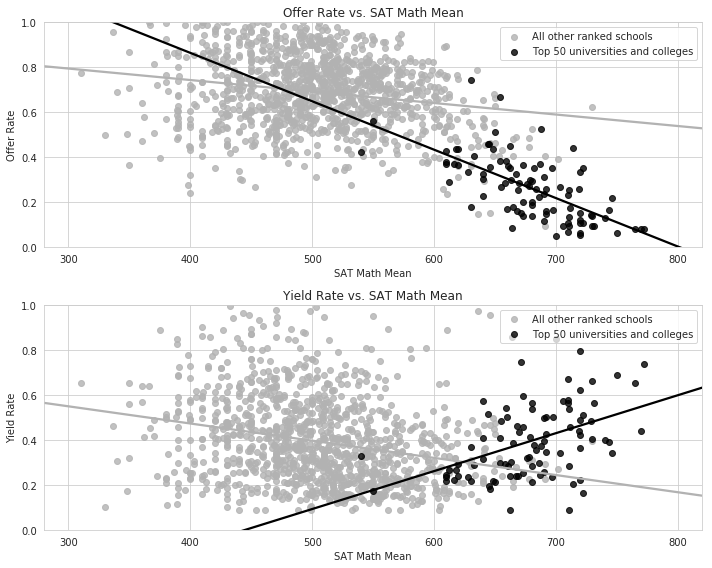

In [50]:
top50 = (df[cat] == 'Top 50 Universities') | (df[cat] == 'Top 50 Colleges')
ranked = df[cat] != 'Unranked Schools'

cols = [('SAT','Math Mean'),('Offer Rate','All'),('Yield Rate','All')]

plot_data = df[cols].copy()
plot_data.columns = plot_data.columns.droplevel(1)
plot_data.columns = ['SAT Math Mean','Offer Rate','Yield Rate']
plot_data.loc[top50, 'Rank Type'] = 'Top 50 Universities and Colleges'
plot_data.loc[~top50 & ranked, 'Rank Type'] = 'All Other Schools'
plot_data['Rank Type'] = plot_data['Rank Type'].astype('category')


f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
ax1.set_ylim(0, 1)
ax1.set_xlim(280, 820)
ax1.set_title('Offer Rate vs. SAT Math Mean')
sns.regplot(x='SAT Math Mean', y='Offer Rate', data=plot_data.loc[~top50 & ranked], 
            color='0.7', label='All other ranked schools', ci=None, ax=ax1)
sns.regplot(x='SAT Math Mean', y='Offer Rate', data=plot_data.loc[top50],
            color='black', label='Top 50 universities and colleges', ci=None, ax=ax1)
ax1.legend(loc='upper right')

ax2.set_ylim(0, 1)
ax2.set_xlim(280, 820)
ax2.set_title('Yield Rate vs. SAT Math Mean')
sns.regplot(x='SAT Math Mean', y='Yield Rate', data=plot_data.loc[~top50 & ranked], 
            color='0.7', label='All other ranked schools', ci=None, ax=ax2)
sns.regplot(x='SAT Math Mean', y='Yield Rate', data=plot_data.loc[top50],
            color='black', label='Top 50 universities and colleges', ci=None, ax=ax2)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

Well, that's a surprise! The Yield Rate is actually *negatively* correlated with the SAT - *except at the most academically competitive schools* where it becomes strongly *positively* correlated.

The Offer Rate is negatively correlated, as expected, though the correlation becomes even stronger the more academically competitive the school becomes.

Based on my experience in college counseling, I am guessing that the 'U'-shaped distribution of Yield Rate against SAT Math (or Yield Rate against any other measure of academic competitiveness) can be explained using Apps per Applicant. My hypothesis is that Applicants with higher SAT scores submit more Applications to schools, especially to more competitive schools (so-called 'reach schools') in addition to easier schools around their competitive level ('match schools') and below ('safety schools').

Higher-scoring students applying to multiple academically competitive reach schools - as well as a few match/safety schools - might end up receiving only a single offer from a reach school, which they will accept, driving up that school's yield rate. Then they will decline the offers they received from their match/safety schools, driving down their yield rates.

For lower-scoring students only aiming for less academically competitive schools with already high offer rates, this strategy of peppering reach schools with many applications might make little sense. The most academically competitive schools are truly beyond any realistic reach and not worth applying, and any realistic schools in their academic range already have high enough offer rates to make it unnecessary to apply to more than a handful to ensure an enrollment somewhere. Since they've applied to less schools, they'll receive fewer offers, and have to turn down fewer schools.

From the point of view of the schools, the least competitive schools are receiving applications from students who are usually only applying to that school, or very few others, and thus the yield rate is high. On the opposite end of the spectrum, the most competitive schools are receiving one of many applications from students, but since the school is so academically competitive and desirable, the offer will likely be accepted, driving up the yield rate, too.

In the middle are the schools inundated with match/safety applications from academically competitive students. When these schools give out offers, they know that most of the applicants will turn them down if they are accepted at a more competitive school. This drives the yield rate down.

Unfortunately, I do not have access to any student-side data - from the Common App perhaps - that could allow me to test the hypothesis that higher scoring students are submitting more apps than lower scoring students.

---

## US News rank

We've been grouping schools by their US News rank type, but we haven't actually investigated what goes into the rank. [You can dive into US News' official methodology](https://www.usnews.com/education/best-colleges/articles/how-us-news-calculated-the-rankings) but we can use our dataset to see that there are some pretty unsurprising strong correlations:

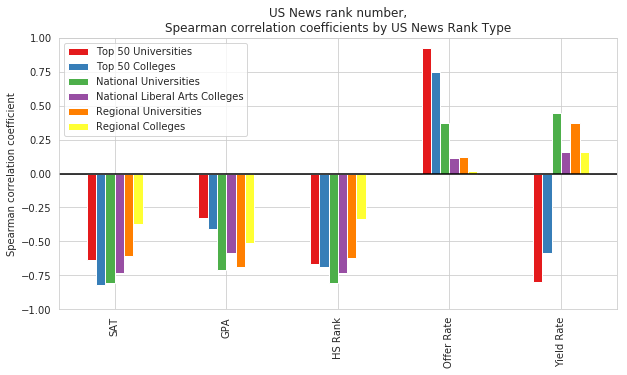

In [51]:
cols = [('SAT','Math Mean'), ('GPA','Mean'), ('HS Rank','Top 10th'), 
        ('Offer Rate','All'), ('Yield Rate','All'), ('Rank','Rank Number')]
corr_coefs = pd.DataFrame(index=cats, columns=cols)

for rank_type in cats:
    mask = df[cat] == rank_type
    corr_coefs.loc[rank_type] = df.loc[mask, cols].corr(method='spearman')['Rank']['Rank Number']
    
corr_coefs.drop(columns=('Rank','Rank Number'), inplace=True)
corr_coefs.drop(index=('Unranked Schools'), inplace=True)
corr_coefs.columns = [col[0] for col in corr_coefs.columns]

f, ax = plt.subplots(1, 1, figsize=(10,5))
corr_coefs.T.plot.bar(ax=ax)
plt.title('US News rank number,\nSpearman correlation coefficients by US News Rank Type')
plt.ylabel('Spearman correlation coefficient')
plt.ylim(-1,1)
plt.axhline(0, color='black', linestyle='solid')
plt.show()

As expected, the Rank Number strongly (negatively) correlates with the SAT, GPA, and HS Top 10th Class Rank (remember it's negative because a lower rank number means a 'higher' ranked school). There's also a weaker *positive* correlation with Offer Rate, which makes sense since the more rare the offers (lower Offer Rate), the better ranking (lower Rank Number) the school.

The Yield Rate, as we previously discussed, has that 'U'-shaped relationship with the SAT (and other measures of academic competitiveness), and the Rank Number is no different. 

---

## US News rank and yield rate

Let's take a look at the Yield Rate plotted against the Rank Number for each rank type group:

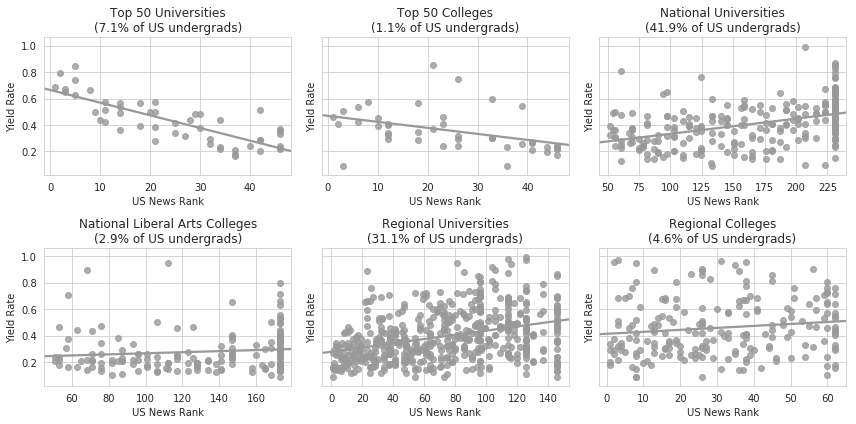

In [19]:
cols = [('Rank','Rank Number'), ('Yield Rate','All'), ('Category','Rank Type')]
mask = df['Category','Rank Type'] != 'Unranked Schools'
plot_data = df.loc[mask, cols]
plot_data.columns = ['Rank','Yield Rate','Rank Type']
plot_data['Rank Type'].cat.remove_unused_categories(inplace=True)

f, axes = plt.subplots(2, 3, figsize=(12,6), sharey=True)
axes = axes.reshape(-1)

for i, rank_type in enumerate(plot_data['Rank Type'].cat.categories):
    mask = plot_data['Rank Type'] == rank_type
    sns.regplot(x='Rank', y='Yield Rate', color='0.6', data=plot_data.loc[mask], ci=None, ax=axes[i])
    ugrad_pct = sums.loc[rank_type, ('Undergrads','Percent of total US undergrads')]
    axes[i].set_title('{}\n({:.1f}% of US undergrads)'.format(rank_type, ugrad_pct))
    axes[i].set_xlabel('US News Rank')
    axes[i].set_ylabel('Yield Rate')


plt.tight_layout()
plt.show()

The Rank Number is a strong predictor of the Yield Rate only at the Top 50 schools. Outside of that, there is a fairly weak opposite correlation (remember the 'U'-shape).

---

## Gender difference in apps

We've explored a lot already about school size and proportion of undergrads as well as the relationships between the US News rank, academic competiveness, offer rates, and yield rates. But now it's time to dive into the gender differences.

Unfortunately, we don't have academic data on the Enrolled freshmen class by gender. But we do have counts of Apps, Offers, Enrolled, and Undergrads split by gender.

Let's first take a look at proportion of Apps that come from women, aggregated by rank type groups:

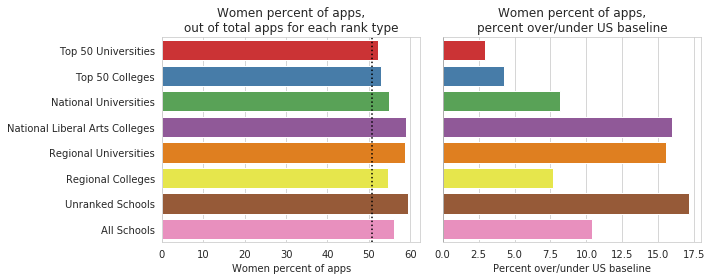

,Apps (men),Apps (women),Women percent of apps,Percent over/under US baseline
Rank Type,,,,
Top 50 Universities,816217,894787,52.30,2.94
Top 50 Colleges,155451,174988,52.96,4.24
National Universities,1646364,2007586,54.94,8.16
National Liberal Arts Colleges,205067,293870,58.90,15.94
Regional Universities,1252842,1781129,58.71,15.56
Regional Colleges,206373,249270,54.71,7.69
Unranked Schools,336764,494836,59.50,17.13
All Schools,4619078,5896466,56.07,10.38


In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)    
sns.barplot(sums['Apps','Percent Women'], sums.index, ax=ax1)
ax1.axvline(US_BASELINE, color='black', linestyle='dotted')
ax1.set_title('Women percent of apps,\nout of total apps for each rank type')
ax1.set_xlabel('Women percent of apps')
ax1.set_ylabel('')

sns.barplot(sums['Apps','Diffs'].values, sums.index, ax=ax2)
ax2.axvline(0, color='black', linestyle='solid')
ax2.set_title('Women percent of apps,\npercent over/under US baseline')
ax2.set_xlabel('Percent over/under US baseline')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# Create and display table below figure.
cols = [('Apps','Men'),('Apps','Women'),('Apps','Percent Women'), ('Apps','Diffs')]
table = sums[cols].copy()
table.columns = table.columns.droplevel(0)
table.columns = ['Apps (men)','Apps (women)',
                 'Women percent of apps',
                 'Percent over/under US baseline']
table

[50.8% of the US population is female, according to the US Census](https://www.census.gov/quickfacts/fact/table/US/PST045217), but ~56.1% of Apps that schools receive come from women. This ~10% excess of women Apps could be due to a higher number of women Applicants, or it could be due to women having a higher Apps per Applicant, or both. Unfortunately, we don't have access to either data and are stuck with just the total number of Apps.

The percentage of Apps from women are higher than the expected 50.8% across all rank type groups, but least so at the Top 50 schools.

---

## Gender difference in offer rates

How do schools Offer Rates compare between the genders considering the large fraction of Apps from women?

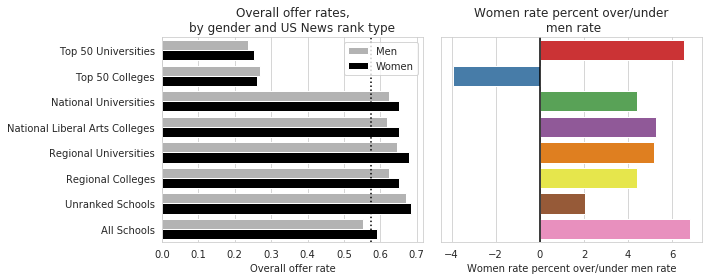

,Offers (men),Offers (women),Offer Rate (men),Offer Rate (women),Women rate percent over/under men rate
Rank Type,,,,,
Top 50 Universities,194195,226784,0.24,0.25,6.53
Top 50 Colleges,42078,45496,0.27,0.26,-3.95
National Universities,1025723,1306076,0.62,0.65,4.42
National Liberal Arts Colleges,126989,191593,0.62,0.65,5.28
Regional Universities,809298,1210006,0.65,0.68,5.17
Regional Colleges,128672,162279,0.62,0.65,4.41
Unranked Schools,225465,338013,0.67,0.68,2.03
All Schools,2552420,3480247,0.55,0.59,6.81


In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)    
plot_data = sums['Offer Rate'][['Men','Women']].reset_index().melt(id_vars='Rank Type', 
                                                                   var_name='Gender', 
                                                                   value_name='Overall offer rate')

sns.barplot(x='Overall offer rate', y='Rank Type', hue='Gender', 
            data=plot_data, palette={'Men':'0.7', 'Women':'black'}, ax=ax1)
ax1.set_title('Overall offer rates,\nby gender and US News rank type')
ax1.set_ylabel('')
ax1.axvline(sums.loc['All Schools',('Offer Rate','All')],
            color='black', linestyle='dotted')
ax1.legend(loc='upper right')

sns.barplot(x=sums['Offer Rate','Diffs'], y=sums.index, ax=ax2)
ax2.set_title('Women rate percent over/under\n men rate')
ax2.set_xlabel('Women rate percent over/under men rate')
ax2.set_ylabel('')
ax2.axvline(0, color='black', linestyle='solid')

plt.tight_layout()
plt.show()

# Create and display table below figure.
cols = [('Offers','Men'),('Offers','Women'),('Offer Rate','Men'), 
        ('Offer Rate','Women'), ('Offer Rate','Diffs')]
table = sums[cols].copy()
table.columns = table.columns.droplevel(0)
table.columns = ['Offers (men)','Offers (women)','Offer Rate (men)',
                 'Offer Rate (women)', 'Women rate percent over/under men rate']
table

Surprisingly, aggregate Offer Rates are higher for women across all rank type groups, except the Top 50 Colleges. Even more surprising is that at the Top 50 Universities, the group with the lowest proportion of Apps from women (though still ~3% above the national proportion of women and ~10% more Apps from women than from Men), the aggregate Offer Rate for women is still ~7% higher than the Offer Rate for men.

Note that the aggregate Offer Rate are all roughly the same (~65%) across all rank type groups, except at the Top 50 schools (~25%).

Also note that there are many more Offers given to women than given to men. I imagine that the gender gap in the Yield Rate - the focus of this entire project - should cause the final Enrolled numbers to even out.

---

## Gender difference in yield rates

Let's look at what the Applicants do with these Offers:

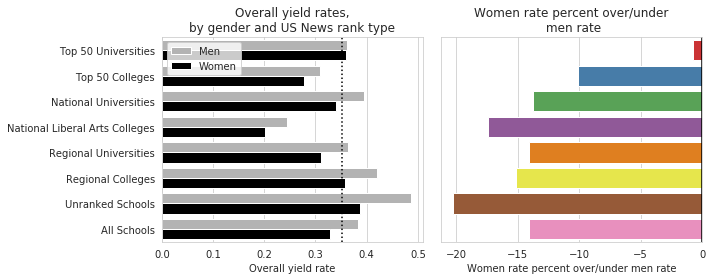

,Enrolled (men),Enrolled (women),Yield Rate (men),Yield Rate (women),Women rate percent over/under men rate
Rank Type,,,,,
Top 50 Universities,70234,81429,0.36,0.36,-0.72
Top 50 Colleges,13016,12652,0.31,0.28,-10.10
National Universities,404032,443819,0.39,0.34,-13.73
National Liberal Arts Colleges,30918,38531,0.24,0.20,-17.40
Regional Universities,293530,377044,0.36,0.31,-14.09
Regional Colleges,54139,57955,0.42,0.36,-15.12
Unranked Schools,109520,130986,0.49,0.39,-20.22
All Schools,975389,1142416,0.38,0.33,-14.10


In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)    
plot_data = sums['Yield Rate'][['Men','Women']].reset_index().melt(id_vars='Rank Type', 
                                                                   var_name='Gender', 
                                                                   value_name='Overall yield rate')

sns.barplot(x='Overall yield rate', y='Rank Type', hue='Gender', 
            data=plot_data, palette={'Men':'0.7', 'Women':'black'}, ax=ax1)
ax1.set_title('Overall yield rates,\nby gender and US News rank type')
ax1.set_ylabel('')
ax1.axvline(sums.loc['All Schools',('Yield Rate','All')],
            color='black', linestyle='dotted')
ax1.legend(loc='upper left')

sns.barplot(x=sums['Yield Rate','Diffs'], y=sums.index, ax=ax2)
ax2.set_title('Women rate percent over/under\n men rate')
ax2.set_xlabel('Women rate percent over/under men rate')
ax2.set_ylabel('')
ax2.axvline(0, color='black', linestyle='solid')

plt.tight_layout()
plt.show()

# Create and display table below figure.
cols = [('Enrolled','Men'),('Enrolled','Women'),('Yield Rate','Men'), 
        ('Yield Rate','Women'), ('Yield Rate','Diffs')]
table = sums[cols].copy()
table.columns = table.columns.droplevel(0)
table.columns = ['Enrolled (men)','Enrolled (women)','Yield Rate (men)',
                 'Yield Rate (women)', 'Women rate percent over/under men rate']
table

The Yield Rate gap is real! But again the Top 50 Universities group is a surprising exception, where the aggregate Yield Rate is virtually identical for men and women. 

Another surprise is how much a hit the National Liberal Arts Colleges takes to the Yield Rate - the lowest rank type group by far. I imagine most of these schools are in the bottom of that 'U'-shaped distribution.

And at the other end of that distribution, we have the Unranked Schools with the highest Yield Rates, especially for men at nearly ~50%. Under my hypothesis, these would be the schools receiving Apps from Applicants mostly applying to only one or two less academically competitive schools.

---

## Gender difference in enrolled

After all the Apps have been received, all the Offers given out, let's see the gender makeup of our aggregate Enrolled freshmen classes:

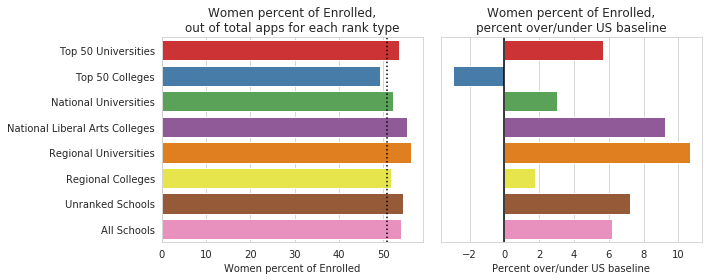

,Enrolled (men),Enrolled (women),Women percent of Enrolled,Percent over/under US baseline
Rank Type,,,,
Top 50 Universities,70234,81429,53.69,5.69
Top 50 Colleges,13016,12652,49.29,-2.97
National Universities,404032,443819,52.35,3.04
National Liberal Arts Colleges,30918,38531,55.48,9.21
Regional Universities,293530,377044,56.23,10.68
Regional Colleges,54139,57955,51.70,1.78
Unranked Schools,109520,130986,54.46,7.21
All Schools,975389,1142416,53.94,6.19


In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)    
sns.barplot(sums['Enrolled','Percent Women'], sums.index, ax=ax1)
ax1.axvline(US_BASELINE, color='black', linestyle='dotted')
ax1.set_title('Women percent of Enrolled,\nout of total apps for each rank type')
ax1.set_xlabel('Women percent of Enrolled')
ax1.set_ylabel('')

sns.barplot(sums['Enrolled','Diffs'].values, sums.index, ax=ax2)
ax2.axvline(0, color='black', linestyle='solid')
ax2.set_title('Women percent of Enrolled,\npercent over/under US baseline')
ax2.set_xlabel('Percent over/under US baseline')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

# Create and display table below figure.
cols = [('Enrolled','Men'),('Enrolled','Women'),('Enrolled','Percent Women'), ('Enrolled','Diffs')]
table = sums[cols].copy()
table.columns = table.columns.droplevel(0)
table.columns = ['Enrolled (men)','Enrolled (women)',
                 'Women percent of Enrolled',
                 'Percent over/under US baseline']
table

Though women make up 50.9% of the American population, they make up ~54% of the aggregate incoming Enrolled freshmen class. They are far from evenly distributed, though. The women percent Enrolled is nearly ~11% over that US baseline at Regional Universities, to ~3% under it at the Top 50 Colleges. 

---


## Summary

Let's put all of this together and see the story of aggregate gender differences from Apps to Undergrads at each of the rank type groups:

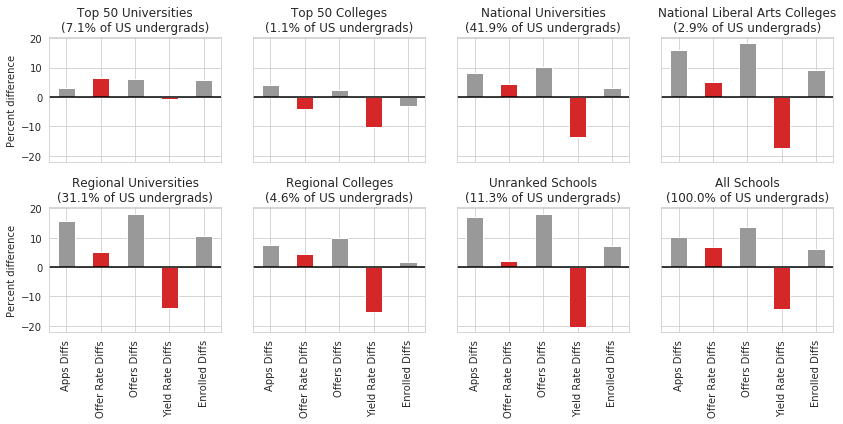

In [67]:
cols = ['Apps', 'Offer Rate', 'Offers', 'Yield Rate', 'Enrolled']
plot_data = sums[cols].xs('Diffs', axis=1, level=1)
plot_data.columns = plot_data.columns + ' Diffs'

f, axes = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)
axes = axes.reshape(-1)

colors = ['0.6'] * 8
colors[1] = 'tab:red'
colors[3] = 'tab:red'
colors[5] = 'tab:red'

for i, rank_type in enumerate(plot_data.index):
    plot_data.loc[rank_type].plot.bar(color=colors, ax=axes[i])
    ugrad_pct = sums.loc[rank_type, ('Undergrads','Percent of total US undergrads')]
    axes[i].set_title('{}\n({:.1f}% of US undergrads)'.format(rank_type, ugrad_pct))
    axes[i].set_ylabel('Percent difference')
    axes[i].axhline(0, color='black')

plt.tight_layout()
plt.show()

To read this, let's look at the National Universities as an example. The first bar, grey, shows a positive gender difference in aggregate Apps, which shows there is ~8% higher percentage of Apps from women than then baseline US percent of women. 

The next bar, red, denotes the diffeernce in Offer Rate, and is also positive. This shows that the Offer Rate for women is ~4% higher than the Offer Rate for men. It has the effect of 'pulling' the next grey bar further up in its direction.

That next grey bar shows the difference in aggregate Offers. There is a ~10% higher percentage of Offers given to women than the US baseline percent of women. 

The next bar, red, shows the Yield Rate difference, and it is *negative* because the Yield Rate for *men* is ~14% higher than the Yield Rate for women. This is going to pull down the next grey bar.

The difference in aggregate students Enrolled, represented by the final grey bar, is pulled down by the negative red Yield Rate bar, showing that the final aggregate women students Enrolled is only slightly above the US baseline.

---

The Offer Rates and subsequent Offers are the decisions of the schools, but the Apps, Yield Rate, and subsequent Enrolled are decisions of the applicants. It appears that there may be a correlation between the Apps differences and the Yield Rate differences - the more imbalanced Apps are, the more (oppositely) imbalanced the Yield Rate becomes. We'll further investigate potential correlations of the Yield Rate gap in the next part.